# Libs utilizadas

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import statsmodels.api as sm
import scipy
from scipy.stats import boxcox
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pyplot import figure
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filtrando warnings
warnings.filterwarnings("ignore")

___

# 1 - Organização dos Dados
> Filtragem da base de dados

Carregando a base bruta

In [194]:
df = pd.read_csv('desepesa_2018_2024.csv', encoding='latin1', sep=';')

In [233]:
dff = df[['UO','DESCRICAO_UO',]].drop_duplicates()

In [234]:
dff.head()

,UO,DESCRICAO_UO
0,30041,SECRETARIA DE ESTADO DE PREVENÇÃO À VIOLÊNCIA
1,20020,SECRETARIA DE ESTADO DA EDUCAÇÃO
2,35032,SECRETARIA DE ESTADO DE TRANSPORTE E DESENVOLV...
3,13017,"SECRETARIA DE ESTADO DO PLANEJAMENTO, GESTÃO E..."
4,34051,SECRETARIA DE ESTADO DE RESSOCIALIZAÇÃO E INCL...


In [195]:
# df1 = pd.read_excel('despesa_2014_2017.xlsx')

In [196]:
# Colunas importantes: ANO, MES, UO, UG, FONTE_MAE, NATUREZA, VALOR_EMPENHADO, VALOR_LIQUIDADO, VALOR_PAGO
dados = df[['ANO', 'MES', 'PODER','UO', 'UG', 'FONTE_MAE', 'NATUREZA3', 'VALOR_EMPENHADO']]

In [197]:
# dados1 = df1[['ANO', 'MES', 'PODER','UO', 'UG', 'FONTE_MAE', 'NATUREZA3', 'VALOR_EMPENHADO']]

In [198]:
dados['UO'].unique()

array([30041, 20020, 35032, 13017, 34051, 29534, 16514, 26031, 16506,
       11504, 19034, 36021, 13511,  3004, 14528, 23542, 18021, 13571,
       14555, 27556, 11006, 27524, 11011,  2501, 19033, 13548,  1002,
       23543, 19047, 17517, 19035, 19512, 17010, 35538, 19049, 14030,
       24037, 13569, 13572, 18520, 14541, 26539, 15024, 11564, 29028,
        2003, 18557, 16026, 91997, 21018, 36522, 16537, 14566, 19036,
       13551, 24547, 11008, 15526, 20516,  2561, 13570, 28027, 24573,
        1500, 11009, 19563, 23032, 29505,  1001, 13510, 21513, 34568,
       29553, 11013, 19565,  3554, 24574, 41516,  1503, 11502, 27023,
       30545, 30567, 27527,  1504, 29032, 24038, 37001, 29031, 11015,
       29533, 29538, 38001, 19536, 29033, 19534, 28507])

In [ ]:
dados

In [199]:
dados = pd.concat([dados, dados1])

In [200]:
dados['ANO_MES'] = dados['ANO'].astype(str) + '-' + dados['MES'].astype(str)

In [201]:
dados = dados.sort_values(by=['ANO', 'MES']).reset_index(drop=True)

In [202]:
# Convertendo para Datetime ANO_MES 
dados['ANO_MES'] = pd.to_datetime(dados['ANO_MES'], format='%Y-%m')

In [203]:
# Transformando em 'Object' ANO, MES, PODER, UO, UG, FONTE_MAE, NATUREZA3.
convertendo_obj = ['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3']
for column in convertendo_obj:
    dados[column] = dados[column].astype('object')

In [204]:
# NATUREZA3 = 331000000 and 331000000 and 345000000 and 346000000
dados = dados[(dados['NATUREZA3'] == 331000000) | 
                  (dados['NATUREZA3'] == 345000000) | 
                  (dados['NATUREZA3'] == 346000000)]
dados = dados[dados['PODER'] == 'EXE'] # Apenas o poder executivo

In [205]:
def analisar_valores_ruins(df, coluna):
    """
    Função para calcular e exibir a porcentagem de valores 0 e negativos, 
    bem como a quantidade de valores ruins em uma coluna específica de um DataFrame.

    Parâmetros:
    df (DataFrame): DataFrame contendo os dados.
    coluna (str): Nome da coluna para análise.

    Retorna:
    None
    """
    # Calcular a porcentagem de valores 0 e negativos em relação ao total
    num_zeros = df[df[coluna] == 0].shape[0]
    num_negativos = df[df[coluna] < 0].shape[0]
    porcentagem_de_zeros_negativos = (num_zeros + num_negativos) / df.shape[0] * 100
    print(f'Porcentagem de valores 0 e negativos: {porcentagem_de_zeros_negativos:.2f}%')

    # Filtrar valores ruins
    df_valores_ruins = df[df[coluna] <= 0]
    print(f'Quantidade de valores ruins: {df_valores_ruins.shape[0]}')
    print(f'Quantidade de valores negativos: {df_valores_ruins[df_valores_ruins[coluna] < 0].shape[0]}')
    print(f'Quantidade de valores 0: {df_valores_ruins[df_valores_ruins[coluna] == 0].shape[0]}')

# Exemplo de uso
# Supondo que 'df_test' seja o DataFrame e 'VALOR_EMPENHADO' seja a coluna a ser analisada
analisar_valores_ruins(dados, 'VALOR_EMPENHADO')

Porcentagem de valores 0 e negativos: 8.02%
Quantidade de valores ruins: 7822
Quantidade de valores negativos: 1097
Quantidade de valores 0: 6725


In [206]:
dados = dados[dados['VALOR_EMPENHADO'] > 0]

In [207]:
# guardar em uma variavel os valores que seriam dropados
dados = dados.dropna()

In [208]:
# Agrupando
dados = dados.groupby('ANO_MES')['VALOR_EMPENHADO'].sum().reset_index()

In [209]:
# Setembro não acabou, então não temos o valor oficial de setembro de 2024
dados = dados[:-1]

In [210]:
dados.index = dados['ANO_MES']

> Dados está pronto para ser análisado

___

# 2 - Análise

Formatação Gŕafica - Padrão

In [211]:
# Formatação para gráficos e tabelas
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500 )
pd.set_option('display.width', 1000)

In [212]:
# Formatando os Labels
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

<Axes: xlabel='ANO_MES'>

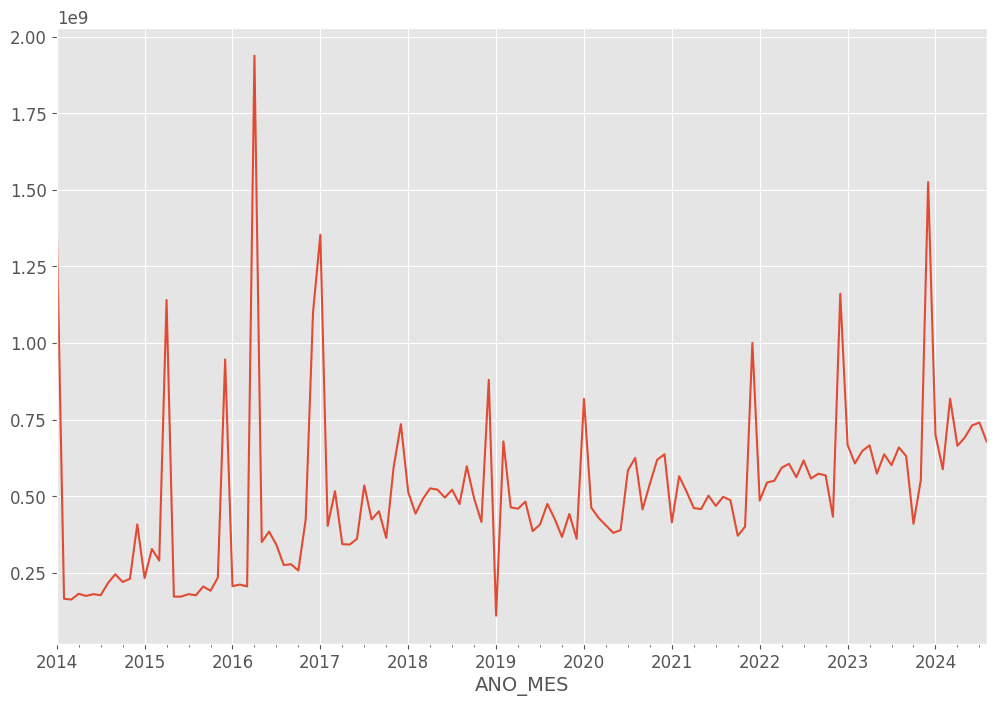

In [213]:
dados['VALOR_EMPENHADO'].plot(figsize=(12,8))

In [214]:
# Decomposição da Série
decomposicao_aditive = sm.tsa.seasonal_decompose(dados['VALOR_EMPENHADO'],
                                                        model='aditive',
                                                        extrapolate_trend='freq')

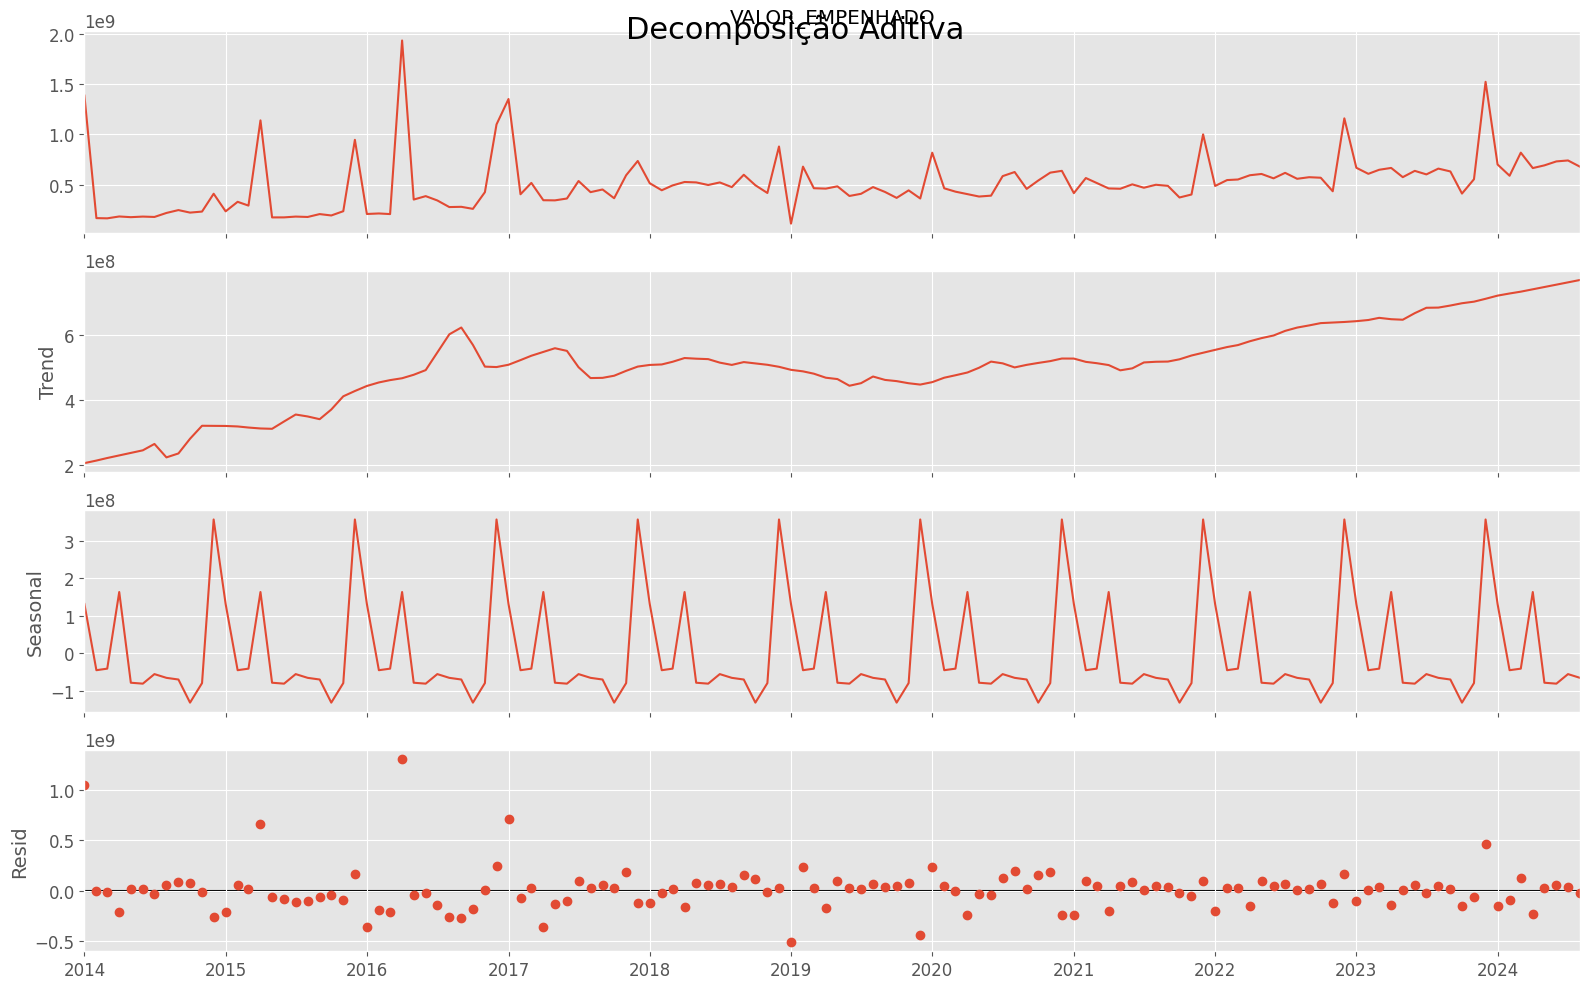

In [215]:
# Plot
plt.rcParams.update({'figure.figsize':(16,10)})
decomposicao_aditive.plot().suptitle("Decomposição Aditiva", fontsize=22)
plt.show()

___

# Teste de Sazionalidade
> Teste Dickey-Fuller Aumentado

# Automatização para testar estacionaridade
> Função para testar estacionaridade da série

*Nesse teste foi definido uma janela de 12 Meses!*

In [216]:
# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

Função em execução.  
> LEMBRETE: Ao executar o teste, é removido 12 meses da amostra! (Configuavel na função "dsa_testa_estacionaridade)

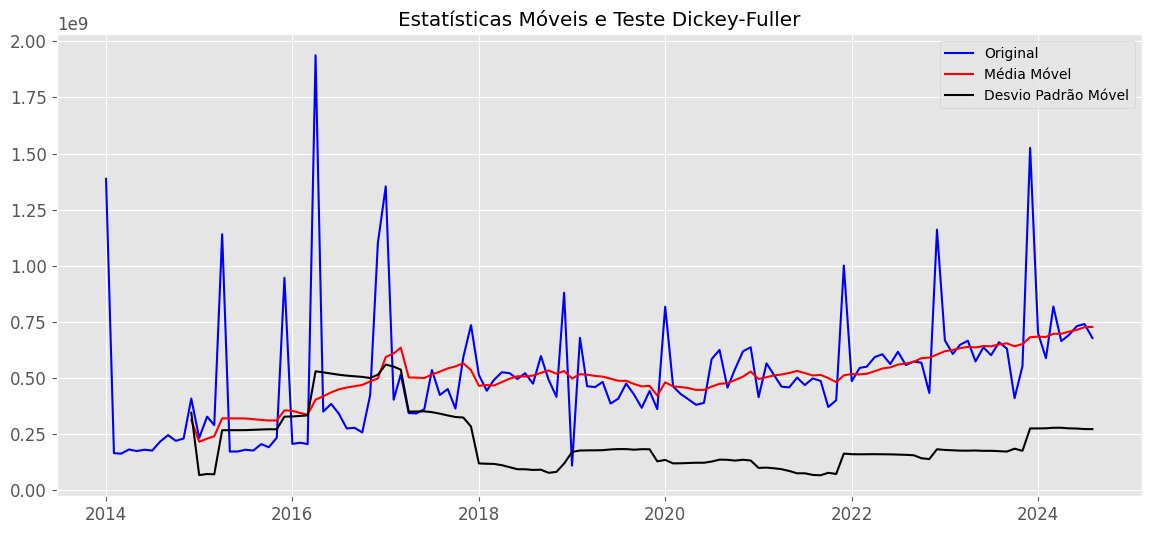


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -1.347136
Valor-p                           0.607341
Número de Lags Consideradas      11.000000
Número de Observações Usadas    116.000000
Valor Crítico (1%)               -3.488022
Valor Crítico (5%)               -2.886797
Valor Crítico (10%)              -2.580241
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [217]:
# Executando nossa função
dsa_testa_estacionaridade(dados['VALOR_EMPENHADO'])

___

# 4 - Transformação em Estacionária

> Métodos para tornar a série estacionária:
- Log  
- Raiz Quadrada
- Box-Cox
- Suavização através da Média Móvel Simples (MMS)
- Suavização através da Média Móvel Ponderada Exponencial (MMPE)
- Diferenciação (existe vários tipos)

> Para esse notebook, foi aplicado apenas transformação de Log. 


### Transformação de LOG
> Aplicando a transformação de LOG

In [218]:
dados.shape

(128, 2)

In [219]:
# Vamos aplicar uma transformação de log usando np.log() e gravamos o resultado em uma nova coluna do nosso dataset
dados['VALOR_EMPENHADO_log'] = np.log(dados['VALOR_EMPENHADO'])
dados.head()

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log
ANO_MES,,,
2014-01-01,2014-01-01,1.387419e+09,21.050711
2014-02-01,2014-02-01,1.649073e+08,18.920894
2014-03-01,2014-03-01,1.627134e+08,18.907501
2014-04-01,2014-04-01,1.813639e+08,19.016016
2014-05-01,2014-05-01,1.744196e+08,18.976974


> Checando estacionáriadade após transformação

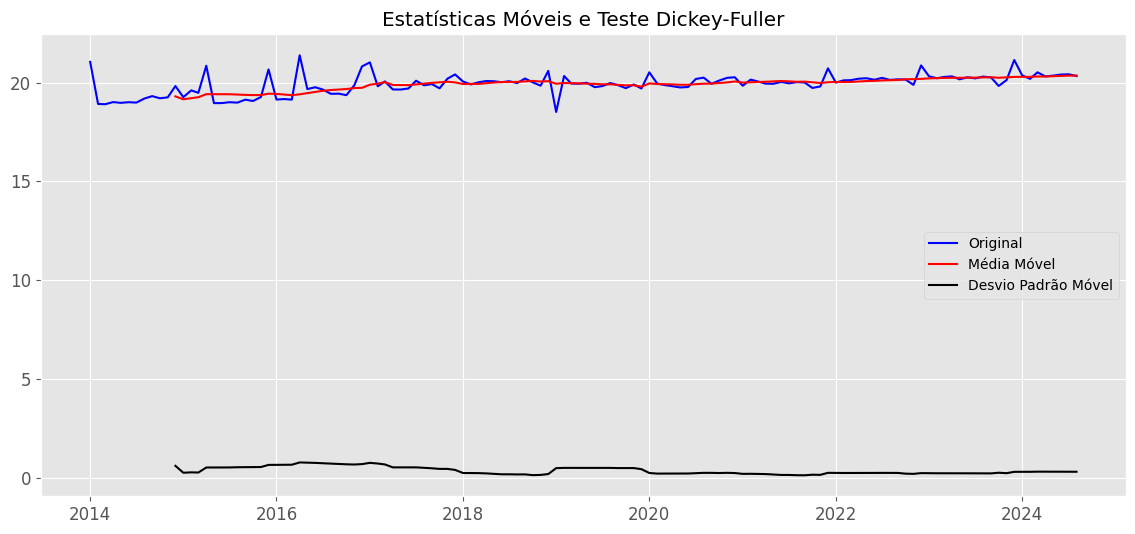


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -1.700966
Valor-p                           0.430615
Número de Lags Consideradas      11.000000
Número de Observações Usadas    116.000000
Valor Crítico (1%)               -3.488022
Valor Crítico (5%)               -2.886797
Valor Crítico (10%)              -2.580241
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [220]:
# Testando Estacionaridade
dsa_testa_estacionaridade(dados['VALOR_EMPENHADO_log'])

___

# 5 - Modelagem
> Suavização Exponencial:

# Exponenial Smoothing

### Ideal quando a série não apresenta tendência e/ou sazionalidade

Exponential Smoothing é uma técnica de modelagem de séries temporais que utiliza uma média móvel ponderada para prever valores futuros de uma série temporal. Cada ponto de dado é atribuído com um peso exponencial decrescente, com os pontos mais recentes recebendo mais peso e os pontos mais antigos recebendo menos peso. O resultado é uma previsão suavizada que leva em consideração tanto a tendência geral quanto a sazonalidade da série temporal.

> Definição de treino e validação

In [221]:
# Faça uma divisão para 80% de treino e 20% de validação
df_treino = dados.iloc[0:100]
df_valid = dados.iloc[100:]

> Criando um Array com os valores da variavel Target em treino

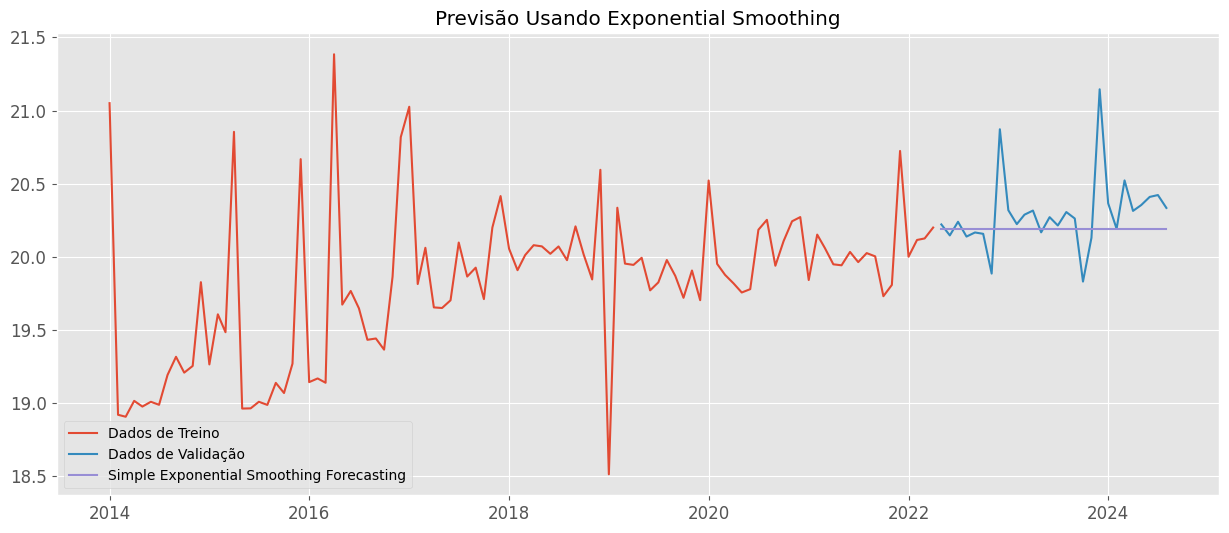

In [222]:
array_VALOR_EMPENHADO_log_treino = np.asarray(df_treino['VALOR_EMPENHADO_log']) # Criamos um array com os valores da variável target em treino

modelo_v1 = SimpleExpSmoothing(array_VALOR_EMPENHADO_log_treino).fit(smoothing_level = 0.9, optimized = True) #  Versão 1 do modelo - Simple Exponential Smoothing 

df_valid['previsoes_v1'] = modelo_v1.forecast(len(df_valid))  # Previsões com o Modelo

# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treino')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

# Define valor real e valor previsto
y_true = df_valid['VALOR_EMPENHADO_log']
y_pred = df_valid.previsoes_v1

___

# Double Exponential Smoothing -> Ideal com tendência
> Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.

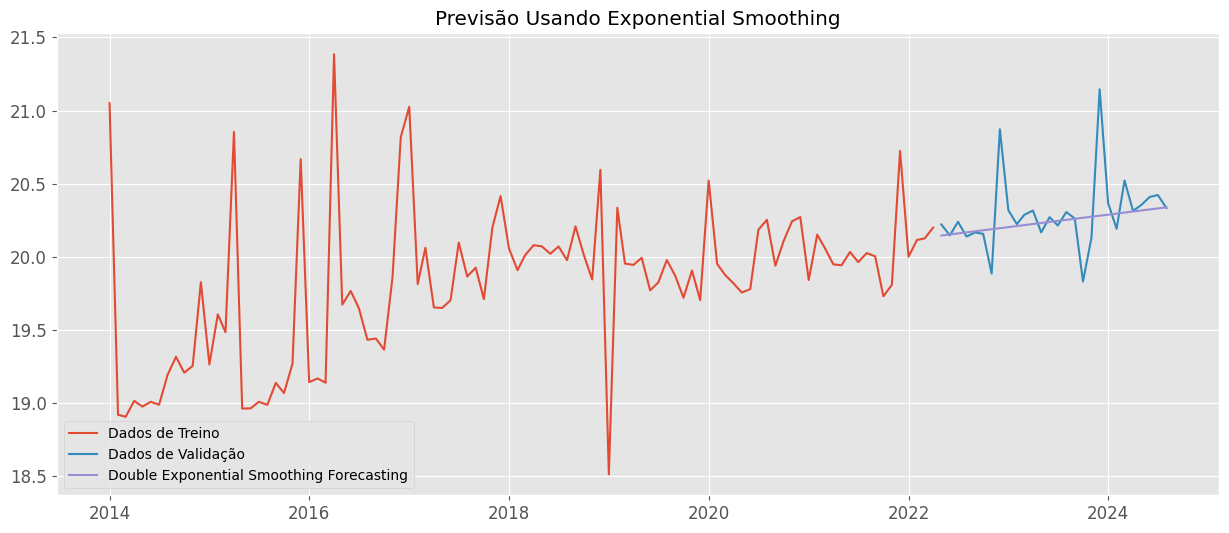

In [223]:
modelo_v2 = ExponentialSmoothing(np.asarray(df_treino['VALOR_EMPENHADO_log']), 
                                 trend = 'additive').fit(smoothing_level = 0.2, 
                                                         optimized = True) 

df_valid.loc[:,'previsoes_v2'] = modelo_v2.forecast(len(df_valid)) # Previsões com o Modelo

# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treino')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v2'], label = 'Double Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()


y_true = df_valid['VALOR_EMPENHADO_log'] # Define valor real e valor previsto
y_pred = df_valid.previsoes_v2

# Triple Exponential Smoothing -> Ideal com Sazionalidade
> Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.


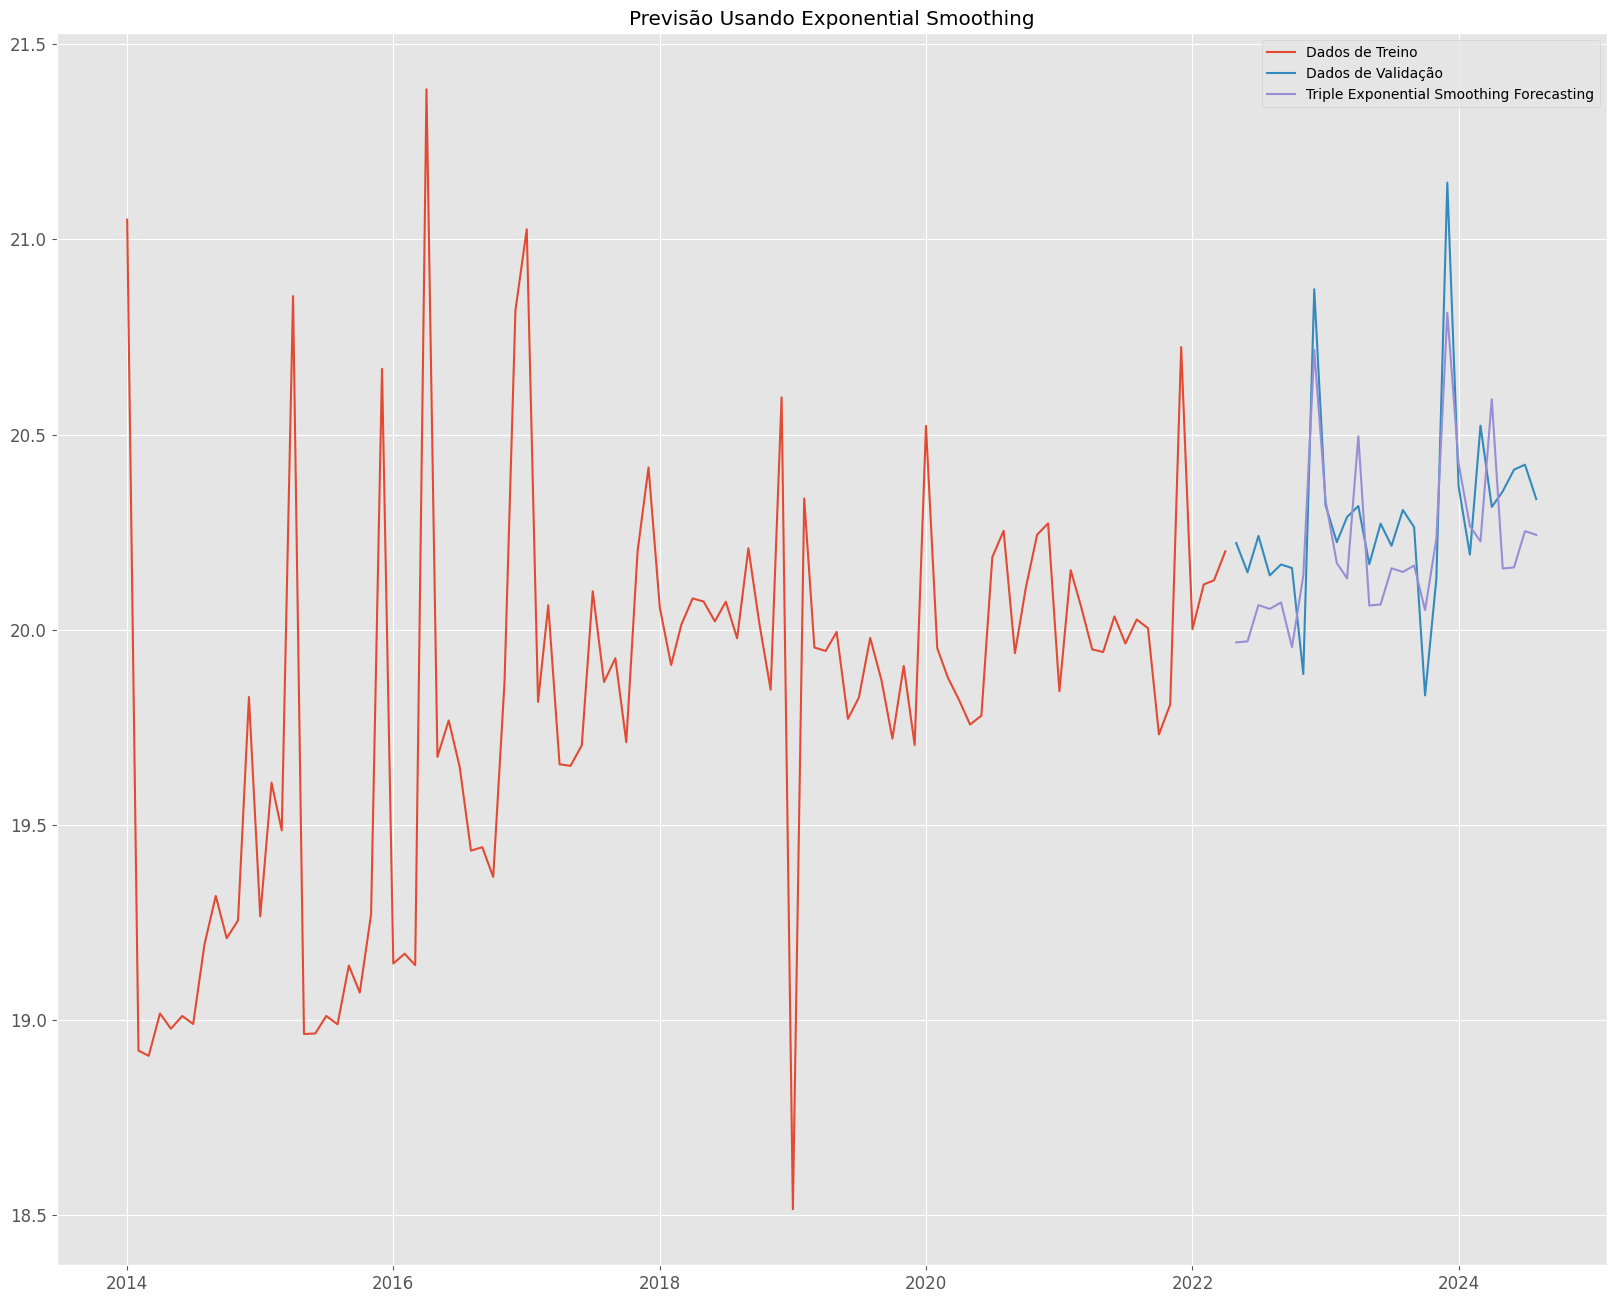

In [224]:
# Triple exponential smoothing 
modelo_v3 = ExponentialSmoothing(np.asarray(df_treino['VALOR_EMPENHADO_log']), # Versão 3 do modelo - Triple Exponential Smoothing
                                 trend = 'multiplicative', # Aditivo ou multiplicativo
                                 seasonal = 'additive', # Aditivo ou multiplicativo
                                 seasonal_periods = 12).fit() # Período sazonal

df_valid.loc[:,'previsoes_v3'] = modelo_v3.forecast(len(df_valid)) # Previsões com o Modelo
df_valid[['VALOR_EMPENHADO_log', 'previsoes_v1', 'previsoes_v2', 'previsoes_v3']].head() # Colocamos lado a lado, valor real e valor "previsto"

# Plot
figure(figsize = (20, 16))
plt.title("Previsão Usando Exponential Smoothing")
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treino')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v3'], label = 'Triple Exponential Smoothing Forecasting')
plt.legend(loc = 'best')
plt.show()

y_true = df_valid['VALOR_EMPENHADO_log'] # Define valor real e valor previsto
y_pred = df_valid.previsoes_v3

> Prevendo para final de 2024

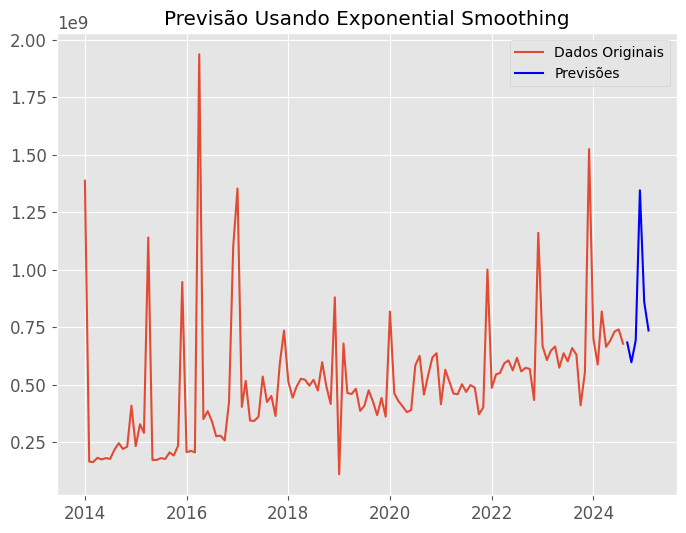

MAE: 0.1608


In [225]:
# Prever para até 2024.12

escolha_periodo = 6 # escolha do usuario

modelo_v4 = ExponentialSmoothing(np.asarray(dados['VALOR_EMPENHADO_log']), # Versão 4 do modelo - Triple Exponential Smoothing
                                 trend='multiplicative', # Aditivo ou multiplicativo
                                 seasonal='additive', # Aditivo ou multiplicativo
                                 seasonal_periods=12).fit() # Período sazonal
previsoes = modelo_v4.forecast(escolha_periodo) # Previsões com o Modelo
previsoes = np.exp(previsoes) # Invertendo a transformação logarítmica
ultima_data = dados.index[-1] # Última data do dataset
datas_previsoes = pd.date_range(start=ultima_data, periods=escolha_periodo, freq='M') # 12 previsões mensais
serie_previsoes = pd.Series(previsoes, index=datas_previsoes) # Criar a série de previsões
dados_com_previsoes = pd.concat([dados['VALOR_EMPENHADO'], serie_previsoes]) # Concatenar

# Plot
figure(figsize=(8, 6))
plt.title("Previsão Usando Exponential Smoothing")
plt.plot(dados['VALOR_EMPENHADO'], label='Dados Originais')
plt.plot(serie_previsoes, label='Previsões', color='blue')
plt.legend(loc='best')
plt.show()

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae:.4f}')

In [226]:
# Dados com previsoes, apenas com 2 casa decimais
dados_com_previsoes = dados_com_previsoes.round(2)
dados_com_previsoes.head()

2014-01-01    1.387419e+09
2014-02-01    1.649073e+08
2014-03-01    1.627134e+08
2014-04-01    1.813639e+08
2014-05-01    1.744196e+08
dtype: float64

In [227]:
# Dados com previsoes, apenas com 2 casa decimais
dados_com_previsoes = dados_com_previsoes.round(2)
dados_com_previsoes.head()

2014-01-01    1.387419e+09
2014-02-01    1.649073e+08
2014-03-01    1.627134e+08
2014-04-01    1.813639e+08
2014-05-01    1.744196e+08
dtype: float64